In [13]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt

from analysis.data_loading import read_hackathon_data
from analysis.metrics.june_dataset import JuNEDataset
from analysis.metrics.metrics_cells import CellsMetrics


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
path = Path("data_config.yaml")
df_hack = read_hackathon_data(path, attach_users=True)
df_hack.head()


hack_db.db


,id,ip_address,time,session_id,kernel_id,notebook_name,event,cell_index,cell_num,cell_type,cell_source,cell_output,expert,user_id
0,10,None,2023-05-06T08:30:38.037Z,a7b38785-5e80-4d1b-9722-6673e4c78877,5c2e86ab-cd96-4e48-98bc-28ed10fa8aac,task1.ipynb,save_notebook,None,NaN,None,"[\n {\n ""id"": ""e4836a849dea49f1a753df2274f...",None,False,student_2
1,17,192.168.1.56,2023-05-06T08:31:35.929Z,a7b38785-5e80-4d1b-9722-6673e4c78877,5c2e86ab-cd96-4e48-98bc-28ed10fa8aac,task1.ipynb,execute,e4836a849dea49f1a753df2274fbdbc5,0.0,code,# # Do not forget to check if your notebook lo...,None,False,student_2
2,18,192.168.1.56,2023-05-06T08:31:35.944Z,a7b38785-5e80-4d1b-9722-6673e4c78877,5c2e86ab-cd96-4e48-98bc-28ed10fa8aac,task1.ipynb,create,dbcf462e8f6c4e3a89c0d6d0d083c0b2,0.0,code,None,None,False,student_2
3,19,192.168.1.56,2023-05-06T08:31:36.049Z,a7b38785-5e80-4d1b-9722-6673e4c78877,5c2e86ab-cd96-4e48-98bc-28ed10fa8aac,task1.ipynb,finished_execute,e4836a849dea49f1a753df2274fbdbc5,1.0,code,# # Do not forget to check if your notebook lo...,"[{""output_type"":""stream"",""size"":23}]",False,student_2
4,41,192.168.1.56,2023-05-06T08:37:46.346Z,a7b38785-5e80-4d1b-9722-6673e4c78877,5c2e86ab-cd96-4e48-98bc-28ed10fa8aac,task1.ipynb,execute,dbcf462e8f6c4e3a89c0d6d0d083c0b2,1.0,code,!ls data/task1,None,False,student_2


In [15]:
june = JuNEDataset(df_hack)
june.to_dataframe().head()


,id,ip_address,time,session_id,kernel_id,notebook_name,event,cell_index,cell_num,cell_type,cell_source,cell_output,expert,user_id
0,10,None,2023-05-06T08:30:38.037Z,a7b38785-5e80-4d1b-9722-6673e4c78877,5c2e86ab-cd96-4e48-98bc-28ed10fa8aac,task1.ipynb,save_notebook,None,NaN,None,"[\n {\n ""id"": ""e4836a849dea49f1a753df2274f...",None,False,student_2
1,17,192.168.1.56,2023-05-06T08:31:35.929Z,a7b38785-5e80-4d1b-9722-6673e4c78877,5c2e86ab-cd96-4e48-98bc-28ed10fa8aac,task1.ipynb,execute,e4836a849dea49f1a753df2274fbdbc5,0.0,code,# # Do not forget to check if your notebook lo...,None,False,student_2
2,18,192.168.1.56,2023-05-06T08:31:35.944Z,a7b38785-5e80-4d1b-9722-6673e4c78877,5c2e86ab-cd96-4e48-98bc-28ed10fa8aac,task1.ipynb,create,dbcf462e8f6c4e3a89c0d6d0d083c0b2,0.0,code,None,None,False,student_2
3,19,192.168.1.56,2023-05-06T08:31:36.049Z,a7b38785-5e80-4d1b-9722-6673e4c78877,5c2e86ab-cd96-4e48-98bc-28ed10fa8aac,task1.ipynb,finished_execute,e4836a849dea49f1a753df2274fbdbc5,1.0,code,# # Do not forget to check if your notebook lo...,"[{""output_type"":""stream"",""size"":23}]",False,student_2
4,41,192.168.1.56,2023-05-06T08:37:46.346Z,a7b38785-5e80-4d1b-9722-6673e4c78877,5c2e86ab-cd96-4e48-98bc-28ed10fa8aac,task1.ipynb,execute,dbcf462e8f6c4e3a89c0d6d0d083c0b2,1.0,code,!ls data/task1,None,False,student_2


In [19]:
june.prepare_dataset()
processor = CellsMetrics()
df = processor.calculate_cell_metrics(june.df)
df

<unknown>:13: SyntaxWarning: invalid decimal literal
<unknown>:13: SyntaxWarning: invalid decimal literal
<unknown>:13: SyntaxWarning: invalid decimal literal
<unknown>:13: SyntaxWarning: invalid decimal literal
<unknown>:13: SyntaxWarning: invalid decimal literal
<unknown>:13: SyntaxWarning: invalid decimal literal
<unknown>:13: SyntaxWarning: invalid decimal literal
<unknown>:13: SyntaxWarning: invalid decimal literal


,id,ip_address,time,session_id,kernel_id,notebook_name,event,cell_index,cell_num,cell_type,cell_source,cell_output,user_id,objects,sloc,ccn
0,10,None,2023-05-06 10:30:38.037,a7b38785-5e80-4d1b-9722-6673e4c78877,5c2e86ab-cd96-4e48-98bc-28ed10fa8aac,task1.ipynb,save_notebook,None,None,None,"[\n {\n ""id"": ""e4836a849dea49f1a753df2274f...",None,student_2,NaN,NaN,NaN
11,11,None,2023-05-06 10:30:47.693,a3faa4bd-d034-41dc-a1a0-b2ac15757097,eeedb543-cbc3-4e59-8e63-511e29518da4,task1.ipynb,save_notebook,None,None,None,"[\n {\n ""id"": ""cc973487bf764ec49c8636c0f02...",None,student_8,NaN,NaN,NaN
13,14,10.82.188.240,2023-05-06 10:31:14.874,a3faa4bd-d034-41dc-a1a0-b2ac15757097,eeedb543-cbc3-4e59-8e63-511e29518da4,task1.ipynb,execute,cc973487bf764ec49c8636c0f02f886c,0.0,code,# # Do not forget to check if your notebook lo...,None,student_8,1.0,2.0,1.0
12,13,10.82.188.240,2023-05-06 10:31:14.883,a3faa4bd-d034-41dc-a1a0-b2ac15757097,eeedb543-cbc3-4e59-8e63-511e29518da4,task1.ipynb,create,b96452a97f01456883542ea0ac111479,0.0,code,None,None,student_8,NaN,NaN,NaN
14,15,10.82.188.240,2023-05-06 10:31:15.115,a3faa4bd-d034-41dc-a1a0-b2ac15757097,eeedb543-cbc3-4e59-8e63-511e29518da4,task1.ipynb,finished_execute,cc973487bf764ec49c8636c0f02f886c,1.0,code,# # Do not forget to check if your notebook lo...,"[{""output_type"":""stream"",""size"":23}]",student_8,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20979,2675,46.223.162.124,2023-07-03 17:11:04.775,7e660212-236c-414c-8326-ef7c28b2f0e2,bb4138c1-dd04-480d-a5b6-d51e1b9048d8,task2.ipynb,execute,63ef60bff06745028aa11ede4424e4fe,30.0,code,"f1_score(y_test_primary, rfclf.predict(prepare...",None,expert_1,5.0,1.0,1.0
20980,2676,46.223.162.124,2023-07-03 17:11:05.060,7e660212-236c-414c-8326-ef7c28b2f0e2,bb4138c1-dd04-480d-a5b6-d51e1b9048d8,task2.ipynb,finished_execute,63ef60bff06745028aa11ede4424e4fe,30.0,code,"f1_score(y_test_primary, rfclf.predict(prepare...","[{""output_type"":""stream"",""size"":471},{""output_...",expert_1,NaN,NaN,NaN
20981,2677,46.223.162.124,2023-07-03 17:12:10.432,7e660212-236c-414c-8326-ef7c28b2f0e2,bb4138c1-dd04-480d-a5b6-d51e1b9048d8,task2.ipynb,create,327eace519e342328b854732db0e883a,10.0,code,None,None,expert_1,NaN,NaN,NaN
20982,2678,46.223.162.124,2023-07-03 17:12:12.134,7e660212-236c-414c-8326-ef7c28b2f0e2,bb4138c1-dd04-480d-a5b6-d51e1b9048d8,task2.ipynb,execute,327eace519e342328b854732db0e883a,11.0,code,class_map,None,expert_1,1.0,1.0,1.0


In [21]:
june = JuNEDataset(df)
evolution_df = june.to_evolution_dataframe()
evolution_df.head()



100%|██████████| 49/49 [00:27<00:00,  1.80it/s]


,state_num,cell_index,cell_num,cell_source,id,ip_address,time,session_id,kernel_id,notebook_name,event,cell_type,cell_output,user_id,objects,sloc,ccn,action_id
0,1,e4836a849dea49f1a753df2274fbdbc5,0.0,# # Do not forget to check if your notebook lo...,10.0,None,2023-05-06 10:30:38.037,a7b38785-5e80-4d1b-9722-6673e4c78877,5c2e86ab-cd96-4e48-98bc-28ed10fa8aac,task1.ipynb,save_notebook,None,None,student_2,NaN,NaN,NaN,10.0
0,2,e4836a849dea49f1a753df2274fbdbc5,0.0,# # Do not forget to check if your notebook lo...,17.0,192.168.1.56,2023-05-06 10:31:35.929,a7b38785-5e80-4d1b-9722-6673e4c78877,5c2e86ab-cd96-4e48-98bc-28ed10fa8aac,task1.ipynb,execute,code,None,student_2,1.0,2.0,1.0,17.0
0,3,e4836a849dea49f1a753df2274fbdbc5,0.0,# # Do not forget to check if your notebook lo...,18.0,192.168.1.56,2023-05-06 10:31:35.944,a7b38785-5e80-4d1b-9722-6673e4c78877,5c2e86ab-cd96-4e48-98bc-28ed10fa8aac,task1.ipynb,create,code,None,student_2,NaN,NaN,NaN,18.0
1,3,dbcf462e8f6c4e3a89c0d6d0d083c0b2,1.0,None,18.0,192.168.1.56,2023-05-06 10:31:35.944,a7b38785-5e80-4d1b-9722-6673e4c78877,5c2e86ab-cd96-4e48-98bc-28ed10fa8aac,task1.ipynb,create,code,None,student_2,NaN,NaN,NaN,18.0
0,4,e4836a849dea49f1a753df2274fbdbc5,0.0,# # Do not forget to check if your notebook lo...,19.0,192.168.1.56,2023-05-06 10:31:36.049,a7b38785-5e80-4d1b-9722-6673e4c78877,5c2e86ab-cd96-4e48-98bc-28ed10fa8aac,task1.ipynb,finished_execute,code,"[{""output_type"":""stream"",""size"":23}]",student_2,NaN,NaN,NaN,19.0


In [22]:
evolution_df.shape


(526205, 18)

In [23]:
def continuous_transform(x, y, size: int = 1000, normalize: bool = True) -> tuple[np.ndarray, np.ndarray]:
    x_max = 1 if normalize else np.max(x)
    xp = np.linspace(0, x_max, size)
    x = np.linspace(0, x_max, len(y))
    y = np.array(y)

    y[np.isnan(y)] = 0
    y = np.interp(xp, x, y) + 1e-5
    return xp, y


In [31]:
evolution_df['task'] = evolution_df.notebook_name.apply(lambda name: 'Task_2' if 'task2' in name else 'Task_1')
evolution_df.head()


,state_num,cell_index,cell_num,cell_source,id,ip_address,time,session_id,kernel_id,notebook_name,event,cell_type,cell_output,user_id,objects,sloc,ccn,action_id,task
0,1,e4836a849dea49f1a753df2274fbdbc5,0.0,# # Do not forget to check if your notebook lo...,10.0,None,2023-05-06 10:30:38.037,a7b38785-5e80-4d1b-9722-6673e4c78877,5c2e86ab-cd96-4e48-98bc-28ed10fa8aac,task1.ipynb,save_notebook,None,None,student_2,NaN,NaN,NaN,10.0,Task_1
0,2,e4836a849dea49f1a753df2274fbdbc5,0.0,# # Do not forget to check if your notebook lo...,17.0,192.168.1.56,2023-05-06 10:31:35.929,a7b38785-5e80-4d1b-9722-6673e4c78877,5c2e86ab-cd96-4e48-98bc-28ed10fa8aac,task1.ipynb,execute,code,None,student_2,1.0,2.0,1.0,17.0,Task_1
0,3,e4836a849dea49f1a753df2274fbdbc5,0.0,# # Do not forget to check if your notebook lo...,18.0,192.168.1.56,2023-05-06 10:31:35.944,a7b38785-5e80-4d1b-9722-6673e4c78877,5c2e86ab-cd96-4e48-98bc-28ed10fa8aac,task1.ipynb,create,code,None,student_2,NaN,NaN,NaN,18.0,Task_1
1,3,dbcf462e8f6c4e3a89c0d6d0d083c0b2,1.0,None,18.0,192.168.1.56,2023-05-06 10:31:35.944,a7b38785-5e80-4d1b-9722-6673e4c78877,5c2e86ab-cd96-4e48-98bc-28ed10fa8aac,task1.ipynb,create,code,None,student_2,NaN,NaN,NaN,18.0,Task_1
0,4,e4836a849dea49f1a753df2274fbdbc5,0.0,# # Do not forget to check if your notebook lo...,19.0,192.168.1.56,2023-05-06 10:31:36.049,a7b38785-5e80-4d1b-9722-6673e4c78877,5c2e86ab-cd96-4e48-98bc-28ed10fa8aac,task1.ipynb,finished_execute,code,"[{""output_type"":""stream"",""size"":23}]",student_2,NaN,NaN,NaN,19.0,Task_1


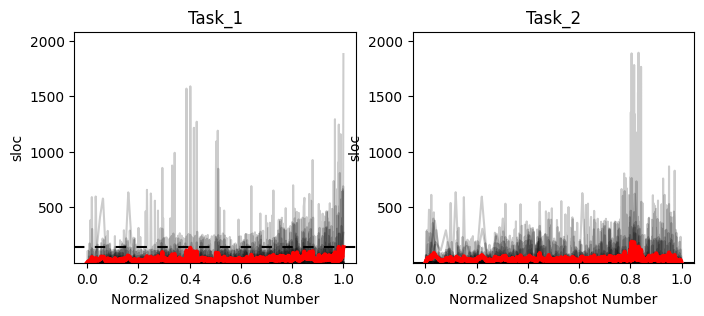

In [38]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
metric_name = 'sloc'
task_ax_mapping = {'Task_1': ax1, 'Task_2': ax2}
mean_curve = {'Task_1': [], 'Task_2': []}

size_threshold = 200
mn, mx = np.inf, -np.inf
for (task, kernel_id), g in evolution_df.groupby(['task', 'kernel_id']):
    if g.shape[0] < size_threshold:
        continue

    x, y = continuous_transform(g.state_num.unique(), g.groupby("state_num")[metric_name].sum(), normalize=True)
    mean_curve[task].append(y)

    mn = y.min() if y.min() < mn else mn
    mx = y.max() if y.max() > mx else mx

    task_ax_mapping[task].plot(x, y, color='k', alpha=0.2)

for task, curves in mean_curve.items():
    y = np.sum(curves, axis=0) / len(curves)
    x = np.linspace(0, 1, len(y))

    task_ax_mapping[task].axhline(y[-1], color='k', ls=(0, (5, 5)))
    task_ax_mapping[task].plot(x, y, color='r', lw=3)

for task, ax in task_ax_mapping.items():
    ax.set_ylim(mn*0.9, mx*1.1)
    ax.set_xlabel('Normalized Snapshot Number')
    ax.set_ylabel(metric_name)
    ax.set_title(task)

